## **DATASET CREATION**

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from langdetect import detect
import re
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from langdetect import detect
import spacy
from tqdm import tqdm
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import os
import matplotlib.pyplot as plt
import little_mallet_wrapper as lmw

/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
politicians= pd.read_csv('politicians_data/politicians_classified.csv')
politicians.drop(politicians.columns[-1], axis=1, inplace=True)

### Preprocessing

In [3]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load stopwords
stop_words_italian = set(stopwords.words('italian'))
stop_words_english = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Load spaCy models for Italian and English
# You need to install these models first using:
nlp_it = spacy.load('it_core_news_sm')
nlp_en = spacy.load('en_core_web_sm')

def preprocess_text(text):
    try:
        # Detect language
        lang = detect(text)
    except:
        lang = 'unknown'
    
    # Remove URLs, mentions, hashtags, and punctuation
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    if lang == 'it':  # Italian
        # Process with spaCy for Italian
        doc = nlp_it(text.lower())
        # Get lemmas and filter stopwords, short words, verbs, and adverbs
        true_tokens = [token.lemma_ for token in doc 
                      if token.text not in stop_words_italian and len(token.text) > 2 and token.pos_ not in ('VERB', 'ADV','AUX')]
    
    elif lang == 'en':  # English
        # Process with spaCy for English
        doc = nlp_en(text.lower())
        # Get lemmas and filter stopwords, short words, verbs, and adverbs
        true_tokens = [token.lemma_ for token in doc 
                      if token.text not in stop_words_english and len(token.text) > 2 and token.pos_ not in ('VERB', 'ADV')]
    
    else: 
        # Fallback to NLTK for spacy errors or mislablings
        tokens = word_tokenize(text.lower())
        true_tokens = [lemmatizer.lemmatize(word) for word in tokens if len(word) > 2]
    
    return true_tokens

# Apply preprocessing to the tweets
politicians_tweets = politicians['Content']

# Method 1: Using tqdm with apply (simpler)
tqdm.pandas(desc="Processing tweets")
politicians['processed_tweet'] = politicians_tweets.progress_apply(lambda x: preprocess_text(x))


[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
Processing tweets: 100%|██████████| 17245/17245 [04:22<00:00, 65.71it/s]


### We divide the politicians in separate datasets with respect to their belief and perform topic modeling using gensim LDA and the and the little MALLET wrapper LDA topic modeling https://github.com/maria-antoniak/little-mallet-wrapper/blob/master/demo.ipynb

### The difference across these two approaches is the following: Gensim typically uses Variational Bayes, which is a different approach compared to MALLET's Gibbs sampling.

### Let's start with the right wing politicians and the gensim LDA approach

In [4]:
right_wing=politicians[politicians['ideology_num'] == 3]
right_wing_processed = right_wing['processed_tweet']
dictionary_right = corpora.Dictionary(right_wing['processed_tweet'])
corpus_right = [dictionary_right.doc2bow(text) for text in right_wing['processed_tweet']]

### We explore which is the best number of topics by computing coherence scores for each LDA model

In [5]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [6]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_right, corpus=corpus_right, texts=right_wing_processed, start=3, limit=45, step=3)

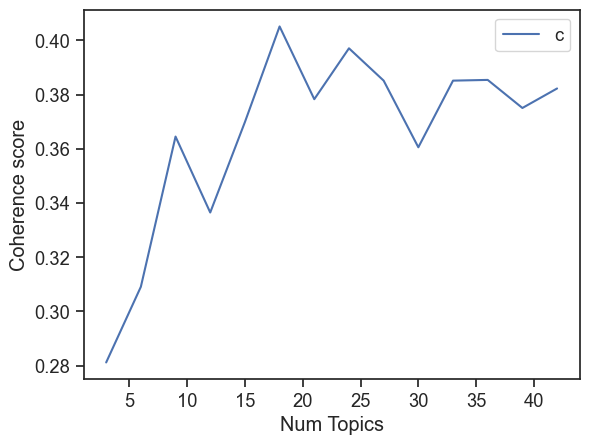

In [7]:
limit=45; start=3; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num -s")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Let's see now the topics obtained from the LDA model with the optimal number of topics

In [8]:
x_list= list(x)
best_num_topics_right_lda = x_list[np.argmax(coherence_values)]
lda_model_right= LdaModel(corpus=corpus_right, id2word=dictionary_right, num_topics=best_num_topics_right_lda, passes=10, random_state=42)
for idx, topic in lda_model_right.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.033*"anno" + 0.020*"vita" + 0.016*"famiglia" + 0.015*"vittima" + 0.014*"abbraccio" + 0.014*"preghiera" + 0.013*"figlio" + 0.010*"ragazzo" + 0.010*"violenza" + 0.010*"ogni"
Topic 1: 0.023*"disabilità" + 0.019*"infrastruttura" + 0.011*"troppo" + 0.011*"napolo" + 0.010*"mercato" + 0.010*"saluto" + 0.010*"mondiale" + 0.009*"stazione" + 0.009*"integrazione" + 0.009*"italy"
Topic 2: 0.060*"sinistra" + 0.020*"elettorale" + 0.019*"campagna" + 0.018*"italiano" + 0.012*"legge" + 0.011*"crescita" + 0.010*"senza" + 0.010*"problema" + 0.010*"ogni" + 0.010*"poltrona"
Topic 3: 0.030*"firma" + 0.018*"alto" + 0.017*"testa" + 0.015*"processo" + 0.015*"opera" + 0.014*"straordinario" + 0.014*"signore" + 0.013*"calabria" + 0.012*"locale" + 0.011*"palermo"
Topic 4: 0.031*"solidarietà" + 0.021*"minaccia" + 0.020*"giornalista" + 0.019*"gente" + 0.017*"insulto" + 0.012*"vergognoso" + 0.012*"autonomo" + 0.011*"libero" + 0.011*"contento" + 0.010*"coraggio"
Topic 5: 0.038*"Italia" + 0.027*"paese" + 0.0

### Let's see a representation of the topics

In [9]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath_right = os.path.join('./results/ldavis_prepared_right'+str(best_num_topics_right_lda))

if 1 == 1:
    LDAvis_prepared_right = gensimvis.prepare(lda_model_right, corpus_right, dictionary_right)
    with open(LDAvis_data_filepath_right, 'wb') as f:
        pickle.dump(LDAvis_prepared_right, f)

with open(LDAvis_data_filepath_right, 'rb') as f:
    LDAvis_prepared_right = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared_right, './results/ldavis_prepared_right'+ str(best_num_topics_right_lda) +'.html')

LDAvis_prepared_right

/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/cor

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.220291 -0.004872       1        1  13.931938
9      0.203445 -0.069525       2        1   7.968844
7      0.129694 -0.019934       3        1   6.917714
14     0.097170  0.004601       4        1   6.814363
5      0.047633  0.063928       5        1   6.651652
0     -0.039715  0.216887       6        1   6.569082
15     0.030556  0.065846       7        1   5.643308
13     0.032179  0.068231       8        1   5.480751
10     0.097801 -0.095944       9        1   5.297484
6     -0.091777  0.089653      10        1   5.011118
17     0.070373 -0.023018      11        1   4.752498
8     -0.108523  0.196042      12        1   4.682548
2     -0.031808 -0.052629      13        1   4.446835
16    -0.078668 -0.076233      14        1   4.098989
3     -0.077092 -0.058173      15        1   3.742132
4     -0.189108 -0.010781      16        1   2.933473
1     -0.195901 -0.135521      17        1   2.839355
11    -0.116551 -0.158557      18        1   2.217917, topic_info=            Term         Freq        Total Category  logprob  loglift
1960        lega   670.000000   670.000000  Default  30.0000  30.0000
237      impresa   406.000000   406.000000  Default  29.0000  29.0000
962     sinistra   535.000000   535.000000  Default  28.0000  28.0000
26       governo  1133.000000  1133.000000  Default  27.0000  27.0000
965        tassa   248.000000   248.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
97        scorso    15.837478    35.019902  Topic18  -4.9798   3.0151
1919     materia    14.042033    26.631990  Topic18  -5.1002   3.1685
1421    chiusura    22.006094    88.800671  Topic18  -4.6509   2.4135
2409  professore    12.284854    31.000035  Topic18  -5.2338   2.8830
5081      chiuso    11.534591    57.535168  Topic18  -5.2969   2.2016

[1044 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2987      5  0.954414  \n\n  
5564     15  0.913180   \n \n
3959      7  0.899416        
5079     15  0.953900  100000
264       1  0.978140     200
...     ...       ...     ...
975      11  0.701854    zero
975      15  0.025066    zero
2119      3  0.931112    zona
2119      7  0.044339    zona
2119     14  0.014780    zona

[2106 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 10, 8, 15, 6, 1, 16, 14, 11, 7, 18, 9, 3, 17, 4, 5, 2, 12])

### Let's see now which topic is assigned to each tweet 

In [10]:
def format_topics_sentences(ldamodel, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel.get_document_topics(corpus)):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    return sent_topics_df


In [11]:
f_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_right, corpus=corpus_right)

# Format
df_dominant_topic = f_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,0,1,0.4607,"disabilità, infrastruttura, troppo, napolo, me..."
1,1,2,0.2512,"sinistra, elettorale, campagna, italiano, legg..."
2,2,10,0.9475,"governo, settimana, piano, vaccinale, paese, e..."
3,3,15,0.4827,"lega, grazie, Roma, cittadinanza, lavoro, salv..."
4,4,14,0.7410,"europeo, libertà, diritto, presidente, parlame..."
5,5,1,0.7229,"disabilità, infrastruttura, troppo, napolo, me..."
6,6,16,0.5351,"clandestino, ministro, sbarco, confine, lamorg..."
7,7,12,0.7256,"governo, italiano, centrodestra, paese, litali..."
8,8,4,0.5030,"solidarietà, minaccia, giornalista, gente, ins..."
9,9,1,0.4509,"disabilità, infrastruttura, troppo, napolo, me..."


### Let's approach now the task with the LDA implementation in the MALLLET wrapper

In [43]:
MALLET_path= '/opt/local/bin/mallet'
output_directory = '/Users/filippofocaccia/Desktop/nlp-project/politicians_data/politicians_filtered'
right_wing['processed_tweet_MALLET']=right_wing['processed_tweet'].apply(lambda x: ' '.join(x))
data_mallet= [t for t in right_wing['processed_tweet_MALLET'].tolist()]


/var/folders/9d/sqxp5kj56832p1mf59mk01gc0000gn/T/ipykernel_8274/1997168028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_wing['processed_tweet_MALLET']=right_wing['processed_tweet'].apply(lambda x: ' '.join(x))


### Let's find the optimal number of topics

In [13]:
def calculate_coherence(topic_keys, training_data, coherence_type='c_v', top_n=10):
    """
    Calculate topic coherence using Gensim's CoherenceModel.
    
    Parameters:
    - topic_keys: List of topic keywords per topic from MALLET
    - training_data: List of tokenized documents
    - coherence_type: Type of coherence to calculate ('c_v', 'u_mass', 'c_uci', or 'c_npmi')
    - top_n: Number of top words to consider
    
    Returns:
    - Average coherence score
    - List of coherence scores per topic (if available)
    """
    # Prepare the tokenized texts
    tokenized_texts = [doc.split() for doc in training_data]
    
    # Create Gensim dictionary
    dictionary = Dictionary(tokenized_texts)
    
    # Prepare topic words (limiting to top_n)
    topics_list = [[word for word in topic[:top_n]] for topic in topic_keys]
    
    # Create coherence model
    coherence_model = CoherenceModel(
        topics=topics_list,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence=coherence_type
    )
    
    # Calculate and return coherence
    coherence_score = coherence_model.get_coherence()
    
    # For some coherence types, we can get per-topic coherence
    try:
        topic_coherences = coherence_model.get_coherence_per_topic()
    except:
        # Not all coherence types support per-topic coherence
        topic_coherences = [coherence_score] * len(topics_list)
    
    return coherence_score, topic_coherences

In [14]:

def find_optimal_topics(path_to_mallet, output_directory_path, training_data, 
                              topic_range=(5, 50, 5), coherence_type='c_v', top_n=10):
    """
    Find the optimal number of topics using Gensim's coherence measures.
    
    Parameters:
    - path_to_mallet: Path to MALLET executable
    - output_directory_path: Directory to save output files
    - training_data: List of tokenized documents
    - topic_range: Tuple of (start, end, step) for number of topics to try
    - coherence_type: Coherence measure to use
    - top_n: Number of top words to consider
    
    Returns:
    - List of number of topics
    - List of corresponding coherence scores
    """
    # Initialize lists to store results
    num_topics_list = list(range(topic_range[0], topic_range[1] + 1, topic_range[2]))
    coherence_scores = []

    # Create training data file once
    path_to_training_data = output_directory_path + '/coherence_training.txt'
    
    # Import data once
    lmw.import_data(path_to_mallet,
                   path_to_training_data,
                   output_directory_path + '/coherence.training',
                   training_data)
    
    # Train models with different numbers of topics
    for num_topics in num_topics_list:
        # Create output directory for this number of topics
        output_directory_num = os.path.join(output_directory_path, str(num_topics))
        if not os.path.exists(output_directory_num):
            os.mkdir(output_directory_num)
            output_directory_path_num = output_directory_num
        else:
            output_directory_path_num = output_directory_num
        print(f"Training model with {num_topics} topics...")
        
        # Train the model
        topic_keys, _ = lmw.quick_train_topic_model(path_to_mallet,
                             output_directory_path_num,
                            num_topics,
                            training_data)
        
        # Calculate coherence using Gensim
        coherence_score, _ = calculate_coherence(
topic_keys, training_data, coherence_type, top_n)
        
        coherence_scores.append(coherence_score)
        print(f"Number of topics: {num_topics}, {coherence_type.upper()} Coherence: {coherence_score:.4f}")
    
    return num_topics_list, coherence_scores


In [15]:
num_topics_list, coherence_scores = find_optimal_topics(
    MALLET_path,
    output_directory,
    data_mallet,
    topic_range=(3, 40, 5),
    coherence_type='c_v',
    top_n=10
)


Importing data...
Complete
Training model with 3 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 3 topics, 2 topic bits, 11 topic mask
Data loaded.
max tokens: 30
total tokens: 102675
<10> LL/token: -8,87883
<20> LL/token: -8,68813
<30> LL/token: -8,60165
<40> LL/token: -8,55696

0	1,66667	anno libertà vita grazie solidarietà donna tutto Roma giustizia italiano forza sindaco sinistra amico tanto violenza uomo altro giorno ogni 
1	1,66667	governo italiano ministro presidente sinistra centrodestra drago litalia europeo primo Italia politico paese cosa cittadino parlamento forza partito tempo proposta 
2	1,66667	lavoro italiano lega impresa famiglia governo nuovo tassa milione sicurezza senza scuola dopo anno lavoratore altro vaccino cittadino paese economico 

<50> LL/token: -8,53249
<60> LL/token: -8,51026
<70> LL/token: -8,49438
<80> LL/token: -8,4801
<90> LL/token: -8,47832

0	1,66667	vita libertà anno grazie tutto solidarietà donna Roma giustizia italiano persona sindaco Italia amico senza mondo violenza giorno uomo due 
1	1,66667	governo italiano sinistra ministro l

Complete
Number of topics: 3, C_V Coherence: 0.4088
Training model with 8 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 30
total tokens: 102675
<10> LL/token: -9,22561
<20> LL/token: -8,93631
<30> LL/token: -8,81767
<40> LL/token: -8,75232

0	0,625	famiglia impresa lavoro vita lega libertà altro mentre milione legge italiano cittadinanza senza figlio diritto lavoratore fiscale miliardo migliaio cittadino 
1	0,625	governo lavoro vaccino scuola drago salute nuovo regione sicurezza piano pubblico misura nazionale priorità sostegno proposta passo riapertura covid pandemia 
2	0,625	litalia italiano altro ministro forte paese governo pronto sinistra Italia nazione storia nessuno risultato tempo solidarietà cittadino minaccia futuro controllo 
3	0,625	italiano lega ministro lavoro tassa casa dopo anno settembre governo lamorgese nuovo sbarco problema primo settembrevotolega clandestino giovane proposta sicurezza 
4	0,625	grazie forza Italia grande giustizia libertà italiano europeo persona amico tutto pace alto centro riforma proprio l

Complete
Number of topics: 8, C_V Coherence: 0.5670
Training model with 13 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 13 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 30
total tokens: 102675
<10> LL/token: -9,32491
<20> LL/token: -9,0078
<30> LL/token: -8,85474
<40> LL/token: -8,76848

0	0,38462	forza Italia Roma grazie difesa centro tutto comune politico valore stato solidarietà parte primo comunità pronto popolo amico giornalista buono 
1	0,38462	anno vita donna vittima famiglia uomo pensiero casa preghiera figlio abbraccio solidarietà due bambino memoria bimbo tutto proprio mamma notizia 
2	0,38462	altro lavoro governo persona lavoratore lega euro primo mila milione cittadinanza dopo famiglia bolletta covid impresa cittadino reddito nessuno pensione 
3	0,38462	impresa famiglia lavoro sostegno nuovo europeo governo gas primo crisi pace miliardo vero litalia energetico economico caro tema risorsa aumento 
4	0,38462	italiano tassa governo lavoro vaccino nuovo casa drago piano sinistra salute proposta salvino priorità idea problema tempo cittadino lega vaccinale 
5	0,38462	

Complete
Number of topics: 13, C_V Coherence: 0.5494
Training model with 18 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 18 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 30
total tokens: 102675
<10> LL/token: -9,39815
<20> LL/token: -9,06445
<30> LL/token: -8,90818
<40> LL/token: -8,8232

0	0,27778	impresa famiglia governo crisi sostegno paese economico energetico gas futuro nucleare soluzione difficoltà energia priorità proposta litalia azienda sicuro vero 
1	0,27778	presidente Roma centrodestra drago elezione governo prossimo senato voto parlamento sinistra paese nazionale elettorale candidato incontro grande mario capitale letto 
2	0,27778	lavoro tassa nuovo lega grazie fiscale italiano buono riforma cartella proposta pace casa taglio esattoriale sud crescita patrimoniale burocrazia tax 
3	0,27778	lavoro lavoratore impresa famiglia altro stato casa luce governo milione lega cittadino pensione caro anno mano aumento posto costo legge 
4	0,27778	scuola sicurezza vaccino persona piano salute lavoro priorità vita paese milione ministro vaccinale governo pubblico rischio ritor

Complete
Number of topics: 18, C_V Coherence: 0.5977
Training model with 23 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 23 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 30
total tokens: 102675
<10> LL/token: -9,45942
<20> LL/token: -9,106
<30> LL/token: -8,94688
<40> LL/token: -8,86441

0	0,21739	solidarietà violenza vittima anno senza vita minaccia morte giustizia libertà diritto preghiera tutto parte pena vicinanza pensiero donna due abbraccio 
1	0,21739	donna uomo vita anno proprio giorno polizia stato carabiniere grazie ogni servizio agente mafia coraggio persona islamico dopo poliziotto rosso 
2	0,21739	Roma grande mondo anno nucleare famiglia sicuro italiano caro ultimo libertà parte sinistra capitale ideologico quello generazione enrico futuro coloro 
3	0,21739	giustizia lega grazie amico referendumgiustizia tutto riforma firma piazza cittadino tanto territorio sindaco gazebo partito Italia bello orgoglioso luglio parlamento 
4	0,21739	città due sicurezza Milano grazie sindaco altro mamma lavoro calabria tanto forza amico figlio giorno Luca fuoco lega candidato pace 

Complete
Number of topics: 23, C_V Coherence: 0.5482
Training model with 28 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 28 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 30
total tokens: 102675
<10> LL/token: -9,51212
<20> LL/token: -9,13871
<30> LL/token: -8,98888
<40> LL/token: -8,89614

0	0,17857	donna ministro violenza altro tutto giorno cittadino uomo rispetto ogni Milano grave bambino quando lamorgese nazione alcuno responsabile servizio attacco 
1	0,17857	forza Italia lavoro uomo buono grazie donna sud sicurezza polizia servizio anno infrastruttura nuovo nord pronto progetto calabria divisa territorio 
2	0,17857	sinistra clandestino Italia italiano lamorgese mentre sbarco immigrato litalia confine Francia limmigrazione altro sotto nulla regola reato dopo Germania porto 
3	0,17857	libertà anno democrazia valore vivo vita libero italiano popolo quello ogni paura violenza civile democratico onore due litalia militare simbolo 
4	0,17857	europeo centro solidarietà pace italiano ruolo parte parlamento tema istituzione tutto Europa russo internazionale dialogo politico ester

Complete
Number of topics: 28, C_V Coherence: 0.5468
Training model with 33 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 33 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 30
total tokens: 102675
<10> LL/token: -9,52569
<20> LL/token: -9,157
<30> LL/token: -9,00201
<40> LL/token: -8,90592

0	0,15152	politico forza Italia senza parte nessuno anno tutto scelta tempo nazionale palazzo bisogno visione proposta società sistema mondo campo quando 
1	0,15152	Roma sindaco città Milano candidato grazie capitale centro bello piazza qualche enrico centrodestra manifestazione sala quartiere ennesimo degrado raggio tutto 
2	0,15152	europeo presidente ministro parlamento consiglio commissione grande paese stato cittadino incontro Europa fondamentale economico Bruxelles risorsa istituzione sostegno nuovo impresa 
3	0,15152	libertà democrazia parte popolo politico libero liberale democratico forza senza altro valore cristiano partito Italia storia centro cina verso violenza 
4	0,15152	primo europeo futuro impegno nazionale intervento quale partito italiano territorio conferenza alleato cultu

Complete
Number of topics: 33, C_V Coherence: 0.5709
Training model with 38 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 38 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 30
total tokens: 102675
<10> LL/token: -9,58171
<20> LL/token: -9,20319
<30> LL/token: -9,03825
<40> LL/token: -8,9597

0	0,13158	anno figlio mamma bimbo pena parola bambino famiglia piccolo casa senza papà carcere padre caro genitore dopo responsabile moglie quello 
1	0,13158	europeo guerra politica difesa paese pace comune valore fondamentale mondo ruolo internazionale estero economico protagonista Europa sicurezza Russia Italia tema 
2	0,13158	ministro lamorgese sinistra parola senza litalia dellinterno clandestino sbarco stato ong solidarietà viminale posto rave illegale ora vergognoso capo profugo 
3	0,13158	italiano sinistra confronto grande tanto massimo altro tutto dopo istituzione foibe giugno problema storico amico simbolo giornalista Venezia medaglia anno 
4	0,13158	economico governo pandemia crisi dopo sanitario italiano speranza situazione stato pass risposta ministro salute sociale fallimento 

Complete
Number of topics: 38, C_V Coherence: 0.5423


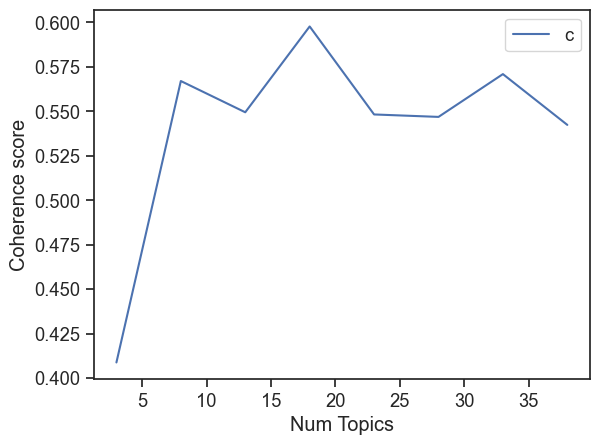

In [16]:
plt.plot(num_topics_list, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_scores"), loc='best')
plt.show()

### We now compute the LDA MALLET model with the optimal number of topics

In [46]:
best_num_topics_MALLET_right= num_topics_list[coherence_scores.index(max(coherence_scores))]
topic_keys, topic_distributions = lmw.quick_train_topic_model(MALLET_path, 
                                                              output_directory, 
                                                              best_num_topics_MALLET_right, 
                                                              data_mallet)

Importing data...
Complete
Training topic model...


Mallet LDA: 18 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 30
total tokens: 102675
<10> LL/token: -9,41875
<20> LL/token: -9,05732
<30> LL/token: -8,90025
<40> LL/token: -8,81835

0	0,27778	italiano casa nuovo miliardo mano intervento problema amico futuro palazzo conto tassa tempo grave energetico ideologico proprio soldo crescita necessario 
1	0,27778	donna anno uomo violenza solidarietà figlio vittima bambino morte polizia diritto famiglia bimbo stato giorno mamma vicinanza carcere ogni servizio 
2	0,27778	europeo guerra cittadino parlamento paese soluzione primo politica ruolo commissione prezzo presidente protagonista governo litalia crisi importante stato istituzione momento 
3	0,27778	Roma sindaco lega grazie città forza centrodestra Milano elettorale regione sinistra campagna prossimo candidato buono cittadino futuro territorio bello tutto 
4	0,27778	governo italiano drago presidente salvino cittadino proposta cartella buonsenso nessuno speranza misura respo

Complete


In [ ]:
topics_right = pd.DataFrame()
text={}
for i, t in enumerate(topic_keys):
    text[i] = ' '.join(t)  # Assign as a single-row DataFrame column
    print(i, '\t', text[i])

topics_right['TopicNumber'] = text.keys()
topics_right['TopicWords'] = text.values()
macros = {0: [1, 4, 11, 12, 13, 15, 17], 1: [0, 5, 6, 14], 2: [2, 3, 7, 8, 9, 10, 16]}
topics=[' National Values and Social Issues',' Economic and Development Issues','Governance and International Relations']
assigned_topics = []
for index,row in topics_right.iterrows():
    if index in macros[0]:
        assigned_topics.append(topics[0])
    elif index in macros[1]:
        assigned_topics.append(topics[1])
    else:
        assigned_topics.append(topics[2])
topics_right['MacroTopic'] = assigned_topics



0 	 nucleare sicuro generazione pulito energetico ultimo energia futuro ricerca gas del ambiente rinnovabile que ideologico mondo fonte para mozione indipendente
1 	 anno donna vita uomo vittima forza famiglia giustizia preghiera due giorno solidarietà italiano tutto memoria grazie pensiero polizia onore servizio
2 	 europeo guerra pace difesa paese politica estero ministro litalia Italia comune russo tema sostegno internazionale presidente protagonista economico Russia ucraino
3 	 Roma sindaco lega città grazie Milano regione cittadino candidato tanto territorio capitale amico calabria squadra amministratore elettorale grande futuro dopo
4 	 governo attività riapertura misura italiano lavoro coprifuoco libertà chiusura senza sicurezza vita cittadino ministro pass buonsenso ristorante zona sanitario greenpass
5 	 famiglia impresa gas bolletta governo crisi caro luce primo economico miliardo lega difficoltà energetico costo prezzo sostegno tempo aiuto proposta
6 	 lavoro tassa impresa l

In [64]:
topics_right
topics_right.to_csv('politicians_data/topics_right.csv', index=False)

- National Values and Social Issues
    This narrative centers on the protection of traditional "famiglia" (family) structures and "valori" (values), with frequent references to "vita" (life), "donna" (woman), "uomo" (man), and "preghiera" (prayer). Right-wing politicians emphasize "solidarietà" (solidarity) and "memoria" (memory) as pillars of Italian identity, constructing a narrative that places family at the nation's core.
    Care for vulnerable populations appears through discussions of "casa" (home), "mamma" (mother), "bimbo" (child), "papà" (father), "figlio" (son/child), "anziano" (elderly), and people with "disabilità" (disabilities), but notably within traditional family frameworks rather than through state welfare expansion.
    Concerns about "libertà" (freedom) and "diritti" (rights) are framed specifically in opposition to "islamico" (Islamic) extremism, "terrorismo" (terrorism), and "regime" (regime) threats like the "talebano" (Taliban), positioning right-wing politicians as defenders of Western civilization against external threats.
    A distinctive element is "anti-sinistra" (anti-left) rhetoric, with frequent mentions of "minaccia" (threats), "violenza" (violence), and "insulto" (insults) allegedly coming from the left, countered with calls for "rispetto" (respect) and "fratello d'italia" (brotherhood of Italy) - also the name of a major right-wing party.
    During the pandemic, right-wing discourse focused critically on "vaccino" (vaccine) policies, "scuola" (school) regulations, "covid" management, and government "misure" (measures). Words like "coprifuoco" (curfew), "chiusura" (closure), "pass" (health pass), and "greenpass" reveal opposition to restrictions, framed as threats to "libertà" (liberty) rather than public health necessities.

- Economic and Development Issues
    The right-wing economic narrative champions "nucleare sicuro" (safe nuclear power) as a "pulito" (clean) and "energetico" (energetic) solution for Italy's "futuro" (future), alongside "gas" and "rinnovabile" (renewable) sources, positioning technological "ricerca" (research) as key to energy independence.
    During economic difficulties, right-wing politicians discuss "impresa" (business) struggles with "bolletta" (utility bills), "caro" (expensive) "luce" (electricity), and "gas" costs. Terms like "crisi" (crisis), "difficoltà" (difficulties), and "costo" (cost) frame economic problems, with "sostegno" (support) and "aiuto" (help) presented as solutions.
    On taxation, right-wing discourse criticizes "tassa" (tax) burdens on "impresa" (businesses) and champions "lavoratore" (worker) interests through "fiscale" (fiscal) reform. References to "cartella" (tax notices), "milione" (millions), "euro", "reddito" (income), and "pensione" (pension) reveal focus on tax relief and economic liberalization rather than government intervention.
    Regional development centers on "lavoro" (work) in both "sud" (south) and "nord" (north), with emphasis on "infrastruttura" (infrastructure), "ponte" (bridge) projects, and "risorsa" (resources). The "sviluppo" (development) narrative presents infrastructure as key to national unity and economic growth.

- Governance and International Relations
    On international matters, right-wing politicians discuss "europeo" (European) affairs, "guerra" (war), "pace" (peace), and "difesa" (defense) through a nationalist lens, emphasizing "litalia" (Italy's) "paese" (country) interests first. The "Russia"-"Ucraina" (Ukraine) conflict is discussed with attention to economic and security implications for Italy.
    European relations use terms like "cooperation," "bilateral," "freedom," and "challenge," suggesting pragmatic engagement while preserving national sovereignty, with "energy" and "value" as recurring themes in international discussions.
    Immigration policy features prominently with "ministro" (minister) statements on "clandestino" (illegal immigrant), "confine" (border), "sbarco" (landings), and "immigrato" (immigrant). Words like "controllo" (control), "regola" (rules), and "illegale" (illegal) construct a security-focused narrative, with explicit criticism of "sinistra" (left-wing) immigration policies.
    Judicial matters focus on "giustizia" (justice) "riforma" (reform) through "referendum" campaigns, with "firma" (signatures), "gazebo" (information stands), and "raccolta" (collection) reflecting grassroots mobilization. The "processo" (legal process) is portrayed as needing conservative reform.
    Local governance highlights "sindaco" (mayor) races in "Roma," "Milano," and other regions, with "lega" (League party) "candidato" (candidates) and "territorio" (territory) concerns. The "squadra" (team) and "amico" (friend) language creates a personal, localized political narrative.
    Right-wing coalition building appears through "centrodestra" (center-right), "forza" (strength/Forza Italia party), and "liberale" (liberal) positioning. "Presidente" (president), "parlamento" (parliament), and references to opposition from the "sinistra" (left) and figures like "conte" and "salvini" complete the governance narrative.

- 1: National Values and Social Issues

    - Topic 1: Focus on family values (woman, life, man, victim, family, prayer, memory, solidarity, honor, service)  
    - Topic 4: COVID restrictions (government, reopening, measures, curfew, liberty, closures, safety, green pass)  
    - Topic 11: COVID management (vaccine, school, government, COVID, health, safety)  
    - Topic 12: Political rhetoric against the left (left, League, journalists, right, Salvini)  
    - Topic 13: Solidarity against threats and violence (solidarity, threats, violence, Brotherhood of Italy, left, respect)  
    - Topic 15: Family care (home, mother, family, children, parents, disability, elderly)  
    - Topic 17: Liberty and rights (freedom, rights, women, democracy, Islamic, violence, human, terrorism, Taliban)  

- 2: Economic and Development Issues

  -  Topic 0: Nuclear energy and environmental policy (nuclear, safe, clean energy, research, gas, renewable)
  -  Topic 5: Economic crisis management (family, business, gas, bills, government, crisis, expensive, energy costs)
  -  Topic 6: Taxation and labor policy (work, tax, business, League, fiscal, workers, citizenship, youth)
  -  Topic 14: National development (work, south, country, development, infrastructure, future, bridge, resources)

- 3: Governance and International Relations

  -  Topic 2: Foreign policy (European, war, peace, defense, country, foreign minister, Russia, Ukraine, international)  
  -  Topic 3: Local governance (Rome, mayor, League, city, Milan, region, citizens, candidates, territory)  
  -  Topic 7: Immigration control (minister, illegal immigrant, Lamorgese, borders, landings, security, immigration)  
  -  Topic 8: Judicial reform (justice, referendum, signatures, reform, League, collection, process)  
  -  Topic 9: Center-right coalition (Italy, strength, center-right, European, country, government, values, party)  
  -  Topic 10: European relations (Europe, Italy, cooperation, bilateral, European, freedom, challenge, Ukraine)  
  -  Topic 16: Government politics (government, Italian, left, president, citizens, country, center-right, parliament, vote)  



### We are now curious to see the contribution of each tweet to the topic like we did in the first approach

In [19]:
def format_topics_documents(topic_distributions, topic_keys, training_data, docs_metadata=None):
    """
    Format the dominant topic for each document in a DataFrame.
    
    Parameters:
    - topic_distributions: The topic distributions from MALLET (from lmw.load_topic_distributions)
    - topic_keys: The topic keywords from MALLET (from lmw.load_topic_keys)
    - training_data: Original documents (for displaying sample text)
    - docs_metadata: Optional metadata for each document (e.g., tweet ID, author, date)
    
    Returns:
    - DataFrame with dominant topic, contribution percentage, and keywords for each document
    """
    # Create a DataFrame for the results
    docs_topics_df = pd.DataFrame()
    
    # Process each document
    for i, doc_topics in enumerate(topic_distributions):
        if i== len(training_data):
            break
        # Find the dominant topic (highest probability)
        dominant_topic_idx = np.argmax(doc_topics)
        dominant_topic_contribution = doc_topics[dominant_topic_idx]
        
        # Get the keywords for this topic
        dominant_topic_keywords = ", ".join(topic_keys[dominant_topic_idx][:10])
        # Create a row for this document
        doc_row = pd.DataFrame({
            'Document_ID': i,
            'Dominant_Topic': int(dominant_topic_idx),
            'Topic_Perc_Contribution': round(dominant_topic_contribution, 4),
            'Topic_Keywords': dominant_topic_keywords,
            'Text_Sample': training_data[i] 
        }, index=[0])
        
        # Add metadata if provided
        if docs_metadata is not None and i < len(docs_metadata):
            for key, value in docs_metadata[i].items():
                doc_row[key] = value
        
        # Append to the results DataFrame
        docs_topics_df = pd.concat([docs_topics_df, doc_row], ignore_index=True)
    
    # Reorder columns if metadata was added
    cols = ['Document_ID', 'Dominant_Topic', 'Topic_Perc_Contribution', 'Topic_Keywords', 'Text_Sample']
    if docs_metadata is not None and len(docs_metadata) > 0:
        metadata_cols = list(docs_metadata[0].keys())
        cols = ['Document_ID'] + metadata_cols + ['Dominant_Topic', 'Topic_Perc_Contribution', 'Topic_Keywords', 'Text_Sample']
    
    # Ensure all expected columns exist
    existing_cols = [col for col in cols if col in docs_topics_df.columns]
    docs_topics_df = docs_topics_df[existing_cols]
    
    return docs_topics_df

In [20]:
tweets_topics_df_right = format_topics_documents(topic_distributions, topic_keys, data_mallet, docs_metadata=None)
tweets_topics_df_right.head(10)

,Document_ID,Dominant_Topic,Topic_Perc_Contribution,Topic_Keywords,Text_Sample
0,0,6,0.8947,"europe, thank, italy, common, cooperation, bil...",congratulation formation new government bilate...
1,1,11,0.6727,"governo, italiano, centrodestra, forza, paese,...",nazione lottimismo lorgoglio unitalia fianco t...
2,2,12,0.6618,"guerra, pace, europeo, paese, difesa, politica...",conversazione telefonico sostegno governo ital...
3,3,4,0.3347,"anno, vita, famiglia, vittima, donna, preghier...",uomo garbato intelligente servitore istituzion...
4,4,12,0.3981,"guerra, pace, europeo, paese, difesa, politica...",libertà religioso obiettivo governo viaggio ir...
5,5,6,0.7340,"europe, thank, italy, common, cooperation, bil...",grazie kurdistan region safety citizen economi...
6,6,6,0.9107,"europe, thank, italy, common, cooperation, bil...",warm welcome erbil today iraq kurdistan region...
7,7,0,0.6623,"impresa, famiglia, gas, bolletta, energetico, ...",prezzo gas calo livello precedente linvasione ...
8,8,6,0.9273,"europe, thank, italy, common, cooperation, bil...",great pleasure speaker iraqi parliament today ...
9,9,6,0.8718,"europe, thank, italy, common, cooperation, bil...",great pleasure eager bilateral relation cooper...


In [35]:
right_wing['Dominant_Topic'] = tweets_topics_df_right['Dominant_Topic']

/var/folders/9d/sqxp5kj56832p1mf59mk01gc0000gn/T/ipykernel_8274/2529070289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_wing['Dominant_Topic'] = tweets_topics_df_right['Dominant_Topic']


In [37]:
#save it as csv
right_wing.to_csv('politicians_data/right_wing.csv', index=False)

### Let's now proceed with left wing politicians, we will do the same analysis done before appying LDA topic modeling from the two different packages

In [21]:
left_wing=politicians[politicians['ideology_num'] == 0]
left_wing_processed = left_wing['processed_tweet']
dictionary_left = corpora.Dictionary(left_wing['processed_tweet'])
corpus_left = [dictionary_left.doc2bow(text) for text in left_wing['processed_tweet']]

### We compute the the coherence to find the optimal number of topics for the LDA model

In [22]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_left, corpus=corpus_left, texts=left_wing_processed, start=3, limit=45, step=3)

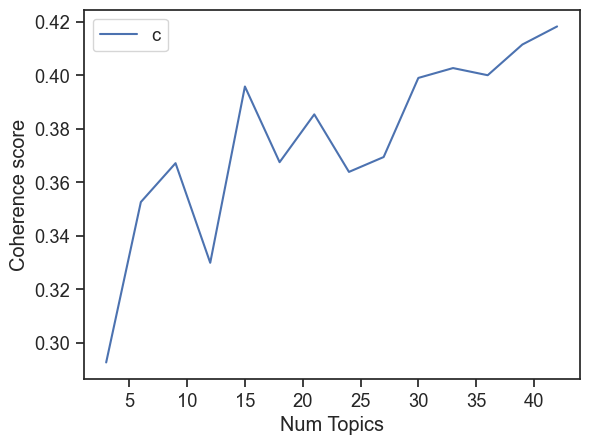

In [23]:
limit=45; start=3; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### We now can compute the gensim LDA model with the optimal number of topics

In [24]:
x_list= list(x)
best_num_topics_left_lda = x_list[np.argmax(coherence_values)]
lda_model_left = LdaModel(corpus=corpus_left, id2word=dictionary_left, num_topics=best_num_topics_left_lda, passes=10, random_state=42)
# 6. Stampa dei topic
for idx, topic in lda_model_left.print_topics(-1):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.103*"giorno" + 0.041*"patrimoniale" + 0.035*"quirinale" + 0.031*"proposta" + 0.029*"presidente" + 0.029*"popolare" + 0.029*"drammatico" + 0.025*"ogni" + 0.024*"grande" + 0.024*"iniziativa"
Topic 1: 0.065*"Roma" + 0.045*"programma" + 0.032*"rifiuto" + 0.027*"fiducia" + 0.025*"democratico" + 0.023*"poco" + 0.022*"terzo" + 0.020*"termovalorizzatore" + 0.019*"profondo" + 0.019*"recovery"
Topic 2: 0.141*"cosa" + 0.070*"nulla" + 0.064*"due" + 0.034*"lega" + 0.031*"regione" + 0.022*"settimana" + 0.021*"anno" + 0.021*"diverso" + 0.017*"dopo" + 0.016*"scorso"
Topic 3: 0.107*"scuola" + 0.053*"candidato" + 0.045*"pubblico" + 0.038*"scelta" + 0.036*"società" + 0.034*"dibattito" + 0.033*"unico" + 0.028*"proprio" + 0.018*"investimento" + 0.017*"tutto"
Topic 4: 0.066*"campagna" + 0.055*"elettorale" + 0.039*"giornalista" + 0.027*"violenza" + 0.027*"differenza" + 0.022*"ogni" + 0.022*"alleanza" + 0.021*"sovranista" + 0.020*"politico" + 0.019*"salare"
Topic 5: 0.080*"ora" + 0.062*"vita" + 0.0

### Let's see a representation of our topics

In [25]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_left'+str(best_num_topics_left_lda))

if 1 == 1:
    LDAvis_prepared_left = gensimvis.prepare(lda_model_left, corpus_left, dictionary_left)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared_left, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared_left, './results/ldavis_prepared_left'+ str(best_num_topics_left_lda) +'.html')

LDAvis_prepared_left

/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/cor

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
29    -0.228647 -0.086468       1        1  4.525449
39    -0.211999 -0.025223       2        1  4.057591
35    -0.170867 -0.101300       3        1  3.739258
31    -0.058256  0.218752       4        1  3.374631
2     -0.133657  0.064001       5        1  3.315222
11    -0.133744 -0.056771       6        1  2.899872
32    -0.093916  0.093900       7        1  2.859730
21    -0.004900  0.138580       8        1  2.744451
13     0.066153 -0.119220       9        1  2.686672
4     -0.046260 -0.046896      10        1  2.675414
33    -0.023218 -0.042136      11        1  2.675177
12    -0.042938 -0.158572      12        1  2.648098
19     0.019846 -0.020233      13        1  2.638544
1     -0.001881  0.151419      14        1  2.599922
41    -0.050315  0.118557      15        1  2.519860
5     -0.032200 -0.069284      16        1  2.512814
22    -0.038290  0.075189      17        1  2.497432
27     0.086183 -0.065961      18        1  2.428555
20     0.027031 -0.030485      19        1  2.395143
0     -0.031157  0.020564      20        1  2.355613
3      0.003644 -0.055704      21        1  2.322042
14    -0.070611  0.029915      22        1  2.313625
25     0.050762 -0.068546      23        1  2.247705
15     0.017291  0.049853      24        1  2.247484
40     0.068507 -0.034925      25        1  2.181726
10     0.018717 -0.003243      26        1  2.144720
6     -0.038783 -0.026297      27        1  2.135625
18     0.033378  0.060689      28        1  2.082398
17     0.020098  0.007542      29        1  1.962945
30     0.087048  0.039514      30        1  1.874187
38     0.069635  0.039638      31        1  1.867470
16     0.046779  0.029787      32        1  1.788903
8      0.036596 -0.040858      33        1  1.768550
37     0.048130  0.033959      34        1  1.760335
28     0.112343 -0.036780      35        1  1.746239
26     0.069473 -0.032793      36        1  1.714476
7      0.094671  0.023638      37        1  1.666186
23     0.079178  0.050819      38        1  1.643412
24     0.111856 -0.047676      39        1  1.631855
34     0.072512 -0.020954      40        1  1.604695
36     0.052694 -0.049419      41        1  1.591352
9      0.119119 -0.006572      42        1  1.554623, topic_info=         Term        Freq       Total Category  logprob  loglift
257    lavoro  738.000000  738.000000  Default  30.0000  30.0000
416     drago  624.000000  624.000000  Default  29.0000  29.0000
45    diritto  518.000000  518.000000  Default  28.0000  28.0000
283      cosa  714.000000  714.000000  Default  27.0000  27.0000
308    destra  518.000000  518.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1071     nero   18.822256   30.244010  Topic42  -4.5428   3.6897
42      tempo   20.226936  290.841026  Topic42  -4.4708   1.4982
123   litalia   18.985026  320.975969  Topic42  -4.5342   1.3362
155     paese   18.539288  789.901017  Topic42  -4.5579   0.4119
859   giovane   13.880919  273.429587  Topic42  -4.8473   1.1834

[1989 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0        12  0.994035       \n\n 
4986     28  0.950967       \n \n
597       3  0.805826        \n  
597      25  0.166723        \n  
377      35  0.977574        \n\n
...     ...       ...         ...
890      18  0.906853         zan
1005     14  0.963245        zero
3638     21  0.943059  zingaretto
3259     18  0.948098       zitto
1878     15  0.968302        zona

[3283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[30, 40, 36, 32, 3, 12, 33, 22, 14, 5, 34, 13, 20, 2, 42, 6, 23, 28, 21, 1, 4, 15, 26, 16, 41, 11, 7, 19, 18, 31, 39, 17, 9, 38, 29, 27, 8, 24, 25, 35, 37, 10])

### MALLET approach


In [26]:
output_directory_left = '/Users/filippofocaccia/Desktop/nlp-project/politicians_data/politicians_filtered_left'
left_wing['processed_tweet_MALLET']=left_wing['processed_tweet'].apply(lambda x: ' '.join(x))
data_mallet_left= [t for t in left_wing['processed_tweet_MALLET'].tolist()]
print(len(data_mallet_left))


9461


/var/folders/9d/sqxp5kj56832p1mf59mk01gc0000gn/T/ipykernel_8274/3453871044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_wing['processed_tweet_MALLET']=left_wing['processed_tweet'].apply(lambda x: ' '.join(x))


### As done before we find the optimal number of topics through coherence computation and then se the specific topics for that number and finally see each tweet assignment to each topic

In [27]:
num_topics_list, coherence_scores = find_optimal_topics(
    MALLET_path,
    output_directory_left,
    data_mallet_left,
    topic_range=(3, 40, 5),
    coherence_type='c_v',
    top_n=10
)


Importing data...
Complete
Training model with 3 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 3 topics, 2 topic bits, 11 topic mask
Data loaded.
max tokens: 33
total tokens: 112395
<10> LL/token: -9,07842
<20> LL/token: -8,9336
<30> LL/token: -8,85886
<40> LL/token: -8,8092

0	1,66667	cosa politica Roma politico quando voto due persona destra modo serio drago programma nulla paese candidato punto proposta campagna altro 
1	1,66667	diritto senza italiano lavoro grazie libertà guerra parte lavoratore grande tutto presidente Italia donna primo governo ucraino paese pace russo 
2	1,66667	governo anno drago lavoro paese conte altro legge politico piano stato crisi salvino partito nuovo buono cosa dopo sinistra covid 

<50> LL/token: -8,77899
<60> LL/token: -8,75364
<70> LL/token: -8,73895
<80> LL/token: -8,72674
<90> LL/token: -8,71087

0	1,66667	politica cosa Roma persona quando politico voto modo due destra nulla senza serio volta programma cittadino ogni candidato punto parola 
1	1,66667	diritto tutto lavoro grazie italiano grande libertà guerra lavoratore paese famig

Complete
Number of topics: 3, C_V Coherence: 0.4706
Training model with 8 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 33
total tokens: 112395
<10> LL/token: -9,40294
<20> LL/token: -9,14151
<30> LL/token: -9,03012
<40> LL/token: -8,95957

0	0,625	guerra ucraino pace russo donna Putin parola grazie tutto giorno solidarietà internazionale parte Italia arma Ucraina presidente popolo anno litalia 
1	0,625	destra cosa conte salvino politica quando melone persona paese senza voto maio poco drago dopo sinistra berluscone giusto ciò stato 
2	0,625	governo crisi lavoro scuola nuovo vaccino impresa pubblico covid italiano sociale altro famiglia costo nazionale ministro intervento pandemia migliore economico 
3	0,625	diritto lavoro lavoratore parlamento governo Italia paese europeo legge nuovo giusto primo grande forza tutto momento mondo ministro parte senza 
4	0,625	Roma piano candidato sindaco cittadino città programma cosa mese altro raggio rifiuto problema ogni fatto secondo dopo grazie proposta conto 
5	0,625	anno idea elettorale c

Complete
Number of topics: 8, C_V Coherence: 0.4736
Training model with 13 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 13 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 33
total tokens: 112395
<10> LL/token: -9,55478
<20> LL/token: -9,26746
<30> LL/token: -9,14235
<40> LL/token: -9,06863

0	0,38462	piano Roma giovane problema ogni proposta euro cittadino tempo investimento milione anno mese priorità lavoro capitale sanità rifiuto cosa fondamentale 
1	0,38462	Roma candidato persona cittadino sindaco sinistra voto città classe dirigente serio politica partito destra quando programma elezione lista elettore lunico 
2	0,38462	governo drago conte salvino destra cosa paese melone litalia elettorale maio campagna senza voto dopo berluscone chiaro italiasulserio quando coalizione 
3	0,38462	scuola presidente anno pubblico nuovo ministro covid vaccino altro situazione comune paese molto studente nessuno repubblica primo poco sinistraitaliano soldo 
4	0,38462	governo drago politico mese primo due politica dopo italiano crisi ministro scelta nulla parlamento senza cosa volta responsabi

Complete
Number of topics: 13, C_V Coherence: 0.4929
Training model with 18 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 18 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 33
total tokens: 112395
<10> LL/token: -9,63523
<20> LL/token: -9,32831
<30> LL/token: -9,1805
<40> LL/token: -9,12111

0	0,27778	giorno presidente ogni dopo persona politico repubblica litalia fatto intervista storia nome istituzione giornale forza volta quirinale istituzionale paese proprio 
1	0,27778	quando campagna salvino melone elettorale parte verità cosa fine anno parola nulla voto stesso persona mafia ultimo responsabilità nessuno bello 
2	0,27778	lavoro diritto lavoratore governo milione paese anno buono comune interesse personale alleanzaverdisinistra dignità parlamento accordo proprio mano salariominimo euro stato 
3	0,27778	drago governo partito politico destra conte liberale paese coalizione salvino politica forza scelta modo maggioranza berluscone litalia serio chiaro patto 
4	0,27778	Roma città candidato programma persona cittadino proposta mese altro comune politica gruppo voto progetto seri

Complete
Number of topics: 18, C_V Coherence: 0.5455
Training model with 23 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 23 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 33
total tokens: 112395
<10> LL/token: -9,70286
<20> LL/token: -9,38513
<30> LL/token: -9,23502
<40> LL/token: -9,15709

0	0,21739	cultura sanità proposta pubblico legge ogni museo bilancio storico mld istruzione soldo grande sinistraitaliano parte libero stato cosa manovra paese 
1	0,21739	tanto altro anno grazie bello cittadino ragazzo stato comune vita richiesta amico istituzione incontro proprio situazione mafia pandemia pnrr movimento 
2	0,21739	valore donna libertà forza melone Italia politico liberale partito salvino berluscone uomo diritto ogni popolare tutto parola resistenza memoria destra 
3	0,21739	guerra ucraino pace russo Putin Ucraina popolo Russia libertà parte europeo internazionale sostegno estero collega italiano forte pieno Bruxelles diplomatico 
4	0,21739	politica cosa serio persona classe italiasulserio dirigente politico drago paese quando proposta modo patto programma partito lunico b

Complete
Number of topics: 23, C_V Coherence: 0.5219
Training model with 28 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 28 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 33
total tokens: 112395
<10> LL/token: -9,73974
<20> LL/token: -9,4048
<30> LL/token: -9,2856
<40> LL/token: -9,2039

0	0,17857	drago europeo presidente grande paese due litalia fine governo consiglio vaccino commissione dopo giusto momento patto scelta messaggio decisione linea 
1	0,17857	governo buono drago giorno dopo presidente cittadinanza forza litalia fine fascista conte fascismo sostegno qualche reddito dato grazie sicurezza politico 
2	0,17857	governo crisi anno quello ragione giorno risposta volta mondo ultimo fiducia scelta problema disastro qualsiasi prossimo dopo realtà danno commento 
3	0,17857	bello confronto idea Roma tutto cosa ogni città terzo quando pronto primo tempo dibattito importante grazie diretta coloro patto volta 
4	0,17857	lavoro lavoratore diritto sociale tanto giovane grazie piazza fianco dignità giorno proprio sindacato donna mafia posto economico legalità ambientale futuro 
5

Complete
Number of topics: 28, C_V Coherence: 0.5318
Training model with 33 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 33 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 33
total tokens: 112395
<10> LL/token: -9,7807
<20> LL/token: -9,45398
<30> LL/token: -9,32314
<40> LL/token: -9,23556

0	0,15152	giorno giustizia solidarietà forza mafia fianco anno verità lotta processo battaglia ogni sociale legalità vita proprio primo incredibile memoria limpegno 
1	0,15152	politica classe dirigente parlamentare politico problema crisi scuola interrogazione stato locale territorio giornalista momento fondo investimento studente amministratore industriale percorso 
2	0,15152	punto volta maio cosa persona problema conte stesso fratoianni anno tutto salvino ruolo felice prossimo drago riferimento fondamentale mese fascista 
3	0,15152	voto cosa politico elettore partito conte governo questione quando ragione politica drago senza altro contrario posizione serio promessa giorno azione 
4	0,15152	lavoro lavoratore governo diritto sindacato sociale sinistraitaliano impresa manovra ministro fami

Complete
Number of topics: 33, C_V Coherence: 0.5199
Training model with 38 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 38 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 33
total tokens: 112395
<10> LL/token: -9,84009
<20> LL/token: -9,52251
<30> LL/token: -9,36301
<40> LL/token: -9,28171

0	0,13158	lavoro lavoratore diritto governo milione sindacato anno piazza euro tassa reddito dignità casa povertà crisi difficoltà licenziamente precario norma lotta 
1	0,13158	candidato Roma sindaco persona serio primo altro programma lista primario elezione cittadino candidatura civico progetto conto calenda nuovo lunico città 
2	0,13158	donna giorno uomo diritto anno grazie nuovo primo sanità paese miliardo problema stato violenza mese strumento grande giovane industriale passo 
3	0,13158	legge sinistraitaliano migrante vergogna patrimoniale ddlzan parlamentare fratoianni proposta grande controllo ricchezza guardia ora via proprio libico iniziativa firma interrogazione 
4	0,13158	voto partito liberale elettore Italia gruppo scelta sinistra popolare stesso democratico coalizione azione 

Complete
Number of topics: 38, C_V Coherence: 0.5117


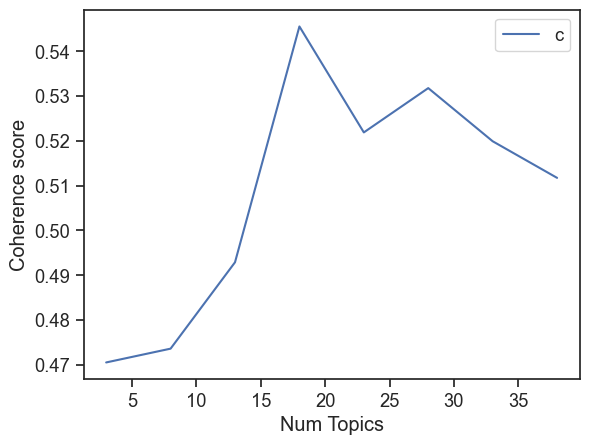

In [28]:
plt.plot(num_topics_list, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_scores"), loc='best')
plt.show()

In [29]:

best_num_topics_MALLET_left= num_topics_list[coherence_scores.index(max(coherence_scores))]

In [30]:
topic_keys_left, topic_distributions_left = lmw.quick_train_topic_model(MALLET_path,
                                                                        output_directory, 
                                                                        best_num_topics_MALLET_left, 
                                                                        data_mallet_left)

Importing data...
Complete
Training topic model...


Mallet LDA: 18 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 33
total tokens: 112395
<10> LL/token: -9,62726
<20> LL/token: -9,32972
<30> LL/token: -9,19729
<40> LL/token: -9,12695

0	0,27778	guerra russo europeo Italia Putin sostegno Ucraina arma pieno internazionale ora militare ministro italiano governodrago necessario litalia inaccettabile collega momento 
1	0,27778	scuola cultura ragazzo storia anno tanto studente famiglia pensiero bello politico coloro vero giovane insulto storico ogni vita perché quartiere 
2	0,27778	drago sinistraitaliano giorno destra voto contrario senza partito coalizione quirinale due patto leader litalia fratoianni nessuno elezione posizione Italia responsabilità 
3	0,27778	nuovo impresa lavoratore governo grazie famiglia lavoro gas altro prezzo casa nazionale energia italiano crisi Italia azienda primo energetico Russia 
4	0,27778	cosa politica conte governo nulla maio persona due campo chiaro scelta voto paese storia giusto secondo poli

Complete


- Left-Wing Italian Political Discourse: Three Major Narratives
    International Relations and Progressive Values
    This narrative weaves together concerns about the "guerra" (war) in "Ucraina" (Ukraine) and "Russia," with left-wing politicians advocating for "pace" (peace) while maintaining "sostegno" (support) through "diplomazia" (diplomacy). The humanitarian dimension focuses on "migranti" (migrants), addressing "tragedie" (tragedies) in the Mediterranean involving people fleeing from "Libia" (Libya), framed through appeals to "solidarietà" (solidarity) and "diritti umani" (human rights).
    These international concerns connect to fundamental values of "libertà" (freedom), "democrazia" (democracy), and "diritti" (rights) within Italian society. The discourse highlights "donna" (women) and gender equality, often linked to historical "resistenza" (resistance) and anti-"mafia" struggles. This creates a narrative connecting progressive politics with Italy's fight against authoritarianism.
    The "europeo" (European) dimension positions Italy within a democratic "Europe," standing against authoritarian figures like "Putin" while advocating for collective action on shared challenges. Words like "valore" (value), "dovere" (duty), and "principio" (principle) permeate this discourse, framing political choices as moral imperatives.
    
- Economic and Social Policy
    This narrative addresses "crisi" (crisis) affecting "famiglie" (families) and "imprese" (businesses), particularly regarding "bollette" (utility bills), "costo" (costs), and "gas" prices. Left-wing politicians propose interventionist measures like "tetto" (price caps), government "intervento" (intervention), and "decreti" (decrees) to protect vulnerable citizens.
    The "pandemia" (pandemic) has shaped discourse around "sanità" (healthcare), "vaccini" (vaccines), and balancing public health with "scuola" (education). This connects to arguments for strengthening "pubblico" (public) services and the welfare state.
    "Lavoro" (work) and worker rights form a cornerstone, with calls for "salario minimo" (minimum wage), "reddito" (income) protections, and more progressive "tasse" (taxes) to address inequality. "Cultura" (culture), "musei" (museums), and "teatro" (theater) are framed not merely as heritage but as vital social assets.
    The narrative emphasizes future "investimenti" (investments) in renewable "energia" (energy), youth "opportunità" (opportunities), and "sociale" (social) programs through "PNRR" (National Recovery and Resilience Plan) and European funding. Terms like "futuro" (future), "piano" (plan), and "programma" (program) signal a forward-looking approach to building a more equitable society.

- Governance and Political Positioning
    This narrative defines left-wing identity against the "destra" (right), with "antifascismo" (anti-fascism) serving as both historical reference and contemporary boundary. Left politicians oppose normalization of far-right ideologies in "stampa" (press), "scuola" (schools), and public discourse.
    "Elezioni" (elections) feature prominently, with discussions of "candidati" (candidates), "coalizione" (coalition), and "primarie" (primaries). Left politicians criticize right-wing leaders like "Meloni," "Salvini," and "Berlusconi," often drawing parallels to international figures like "Trump."
    The discourse includes reflections on "politica" (politics) itself, with the "sinistra" (left) positioning itself against "populismo" (populism). Terms like "serio" (serious) and "responsabile" (responsible) characterize the self-image of left parties as alternatives to right-wing governance.
    "Roma" city management highlights issues like "rifiuti" (waste), "servizi" (services), and "quartieri" (neighborhoods), while broader "governo" (government) discussions address "parlamento" (parliament), "presidente" (president), and the "Quirinale" (presidential palace politics).
    Throughout runs an aspirational tone about "cittadini" (citizens), "futuro" (future), and "importanza" (importance) of good governance, balancing critique with an affirmative vision using words like "grazie" (thank you), "bello" (beautiful), and "buono" (good) to convey optimism about left-wing leadership possibilities

Category 1: International Relations and Progressive Values

- 0: War and diplomacy (Ukraine-Russia conflict, Putin, peace, European, arms, international relations, diplomatic support)
- 5: Migration and humanitarian concerns (migrants, families, victims, Libya, human rights, solidarity, tragedies)
- 7: Liberty and democratic principles (freedom, rights, democracy, duties, politics, society, liberalism, culture, values)
- 8: Solidarity and social justice (solidarity, women, liberty, rights, values, resistance, memory, anti-mafia stance)
- 11: European and international democracy (Europe, democracy, Ukraine, European integration, freedom)

Category 2: Economic and Social Policy
-  3: Economic crisis management (businesses, families, bills, government, costs, proposals, price caps, interventions)
-  6: COVID and healthcare (vaccines, COVID, schools, pandemic, public health, vaccination plans, health passes)
-  12: Labor rights and economic justice (work, workers, rights, laws, income, taxes, unions, youth, minimum wage)
-  14: Cultural development (culture, museums, history, youth, arts, theater, cultural heritage)
-  15: Future-oriented investments (proposals, youth, gas, European investments, schools, energy, public health, social programs)

Category 3: Governance and Political Positioning

-  1: Anti-fascism and education (government, parliament, left Italian, fascism, students, schools, press freedom)
- 2: Electoral politics (candidates, Conte, right, Rome, voting, coalitions, primaries, mayoral races)
- 4: Political discourse (politics, politicians, reasoning, country governance, approaches to issues)
- 9: Left vs. right political framing (politics, left, right, country, parties, serious politics, electoral proposals)
- 10: Opposition to right-wing leadership (leadership critique, Meloni, Salvini, Trump, Berlusconi, electoral concerns)
- 13: Positive governance messaging (gratitude, work, citizenship, mayors, city management, future planning)
- 16: Rome city management (Rome, waste management, municipal services, city programs, neighborhoods, capital city)
- 17: Government politics (government, parliament, president, Conte, political maneuvering, majority coalition, Quirinale)

In [31]:
tweets_topics_df = format_topics_documents(topic_distributions_left, topic_keys_left, data_mallet_left, docs_metadata=None)
tweets_topics_df.head(10)

,Document_ID,Dominant_Topic,Topic_Perc_Contribution,Topic_Keywords,Text_Sample
0,0,13,0.6842,"tanto, grazie, bello, grande, lavoro, litalia,...",anno dallomicidio Sergio ramello speciale rai ...
1,1,13,0.3040,"tanto, grazie, bello, grande, lavoro, litalia,...",presidente senato gruppo senatore disegno legg...
2,2,7,0.2902,"libertà, diritto, democrazia, dovere, politica...",auspico spirito teatro scala tutto forza polit...
3,3,17,0.4201,"drago, governo, parlamento, presidente, conte,...",trovo inaccettabile lattacco pina picierno pie...
4,4,17,0.5841,"drago, governo, parlamento, presidente, conte,...",mese pericoloso escalation minaccia violenza m...
5,5,1,0.2799,"governo, parlamentare, interrogazione, ministr...",esprimo ferma condanna vergognoso frase minist...
6,6,4,0.3454,"cosa, politica, quando, ogni, politico, person...",sincera vicinanza primo consigliere dellambasc...
7,7,8,0.8505,"donna, solidarietà, libertà, diritto, tutto, v...",violenza genere fenomeno criminale sociale gra...
8,8,8,0.5122,"donna, solidarietà, libertà, diritto, tutto, v...",occasione 42esimo anniversario terremoto irpin...
9,9,4,0.2912,"cosa, politica, quando, ogni, politico, person...",autonomia lunità nazionale


In [ ]:
topics_left= pd.DataFrame()
text={}
for i, t in enumerate(topic_keys_left):
    text[i] = ' '.join(t)  # Assign as a single-row DataFrame column
    print(i, '\t', text[i])

topics_left['TopicNumber'] = text.keys()
topics_left['TopicWords'] = text.values()
macros = {0: [0,5,7,8,11], 1: [3,6,12,14,15], 2: [1,2,4,9,10,16,17]}
topics=[' International Relations and Progressive Values',' Economic and Social Policy ','Governance and Political Positioning']
assigned_topics = []
for index,row in topics_right.iterrows():
    if index in macros[0]:
        assigned_topics.append(topics[0])
    elif index in macros[1]:
        assigned_topics.append(topics[1])
    else:
        assigned_topics.append(topics[2])
topics_left['MacroTopic'] = assigned_topics



0 	 guerra ucraino russo pace Putin europeo Ucraina arma Russia internazionale Italia paese estero italiano collega popolo sostegno governo diplomatico civile
1 	 governo parlamentare interrogazione ministro fascismo studente sinistraitaliano scuola parola vicenda destra perché consigliere organizzazione fascista ragazzo renzi lamorgese stampa giornalista
2 	 candidato maio destra conte Roma voto drago cosa raggio campo elettorale secondo primo fratoianni accordo collegio coalizione campagna primario sindaco
3 	 impresa famiglia bolletta governo prezzo euro costo tetto miliardo proposta nuovo intervento italiano crisi aumento anno altro gas cittadino azienda
4 	 cosa politica quando ogni politico persona ragione nulla senza altro anno giorno volta due parte fatto italiano paese modo molto
5 	 anno migrante famiglia italiano vittima dolore libico vita tragedia giustizia pensiero libia persona ora governo guardia illegale processo scomparsa umano
6 	 vaccino covid scuola pandemia sanità 

In [73]:
topics_left
topics_left.to_csv('politicians_data/topics_left.csv', index=False)

In [69]:
left_wing['Dominant_Topic'] = tweets_topics_df['Dominant_Topic']
#save it as csv
left_wing.to_csv('politicians_data/left_wing.csv', index=False)

/var/folders/9d/sqxp5kj56832p1mf59mk01gc0000gn/T/ipykernel_8274/542321673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_wing['Dominant_Topic'] = tweets_topics_df['Dominant_Topic']


In [70]:
left_wing.head()

,Unnamed: 0,Date,ID,Content,Likes,politician,party,ideology_num,processed_tweet,processed_tweet_MALLET,Dominant_Topic
1894,2602,2022-12-12 09:34:43+00:00,1602235491792965640,"A 47 anni dall’omicidio di Sergio Ramelli, uno...",1204,LaRussa,FdI,0,"[anno, dallomicidio, Sergio, ramello, speciale...",anno dallomicidio Sergio ramello speciale rai ...,9.0
1895,2603,2022-12-11 14:01:09+00:00,1601940150195462144,"Ho predisposto, ma non lo presenterò io perché...",1380,LaRussa,FdI,0,"[presidente, senato, gruppo, senatore, disegno...",presidente senato gruppo senatore disegno legg...,15.0
1896,2604,2022-12-10 09:15:01+00:00,1601505754854219776,Auspico che lo spirito del Teatro alla Scala i...,126,LaRussa,FdI,0,"[auspico, spirito, teatro, scala, tutto, forza...",auspico spirito teatro scala tutto forza polit...,3.0
1897,2605,2022-12-09 16:25:35+00:00,1601251723930370051,Trovo inaccettabile l'attacco rivolto all'euro...,359,LaRussa,FdI,0,"[trovo, inaccettabile, lattacco, pina, piciern...",trovo inaccettabile lattacco pina picierno pie...,15.0
1898,2609,2022-12-06 11:29:57+00:00,1600090160221200384,Da mesi assistiamo ad una pericolosa escalatio...,602,LaRussa,FdI,0,"[mese, pericoloso, escalation, minaccia, viole...",mese pericoloso escalation minaccia violenza m...,3.0
